In [2]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash
    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

<3>WSL (24 - Relay) ERROR: CreateProcessParseCommon:863: Failed to translate c:\Users\user\Desktop\RL
<3>WSL (24 - Relay) ERROR: CreateProcessParseCommon:909: getpwuid(0) failed 2
<3>WSL (24 - Relay) ERROR: UtilTranslatePathList:2878: Failed to translate c:\Users\user\AppData\Local\Microsoft\WindowsApps
<3>WSL (24 - Relay) ERROR: UtilTranslatePathList:2878: Failed to translate c:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\Scripts
<3>WSL (24 - Relay) ERROR: UtilTranslatePathList:2878: Failed to translate C:\Users\user\AppData\Local\cloud-code\installer\google-cloud-sdk\bin
<3>WSL (24 - Relay) ERROR: UtilTranslatePathList:2878: Failed to translate C:\Program Files (x86)\VMware\VMware Workstation\bin\
<3>WSL (24 - Relay) ERROR: UtilTranslatePathList:2878: Failed to translate C:\Program Files\Axiom\AxiomJDK-Pro-21\bin\
<3>WSL (24 - Relay) ERROR: UtilTranslatePathList:2878: Failed to translate C:\Windows\System32\

In [3]:
import gymnasium as gym
import numpy as np
import random
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

In [4]:
env = gym.make("FrozenLake-v1", is_slippery=True, render_mode="rgb_array")

state_size = env.observation_space.n
action_size = env.action_space.n

In [5]:
def q_table_init(state_size, action_size):
    q_table = np.zeros((state_size, action_size))
    return q_table


In [6]:
def choose_action(q_table, state, epsilon):
    if random.uniform(0, 1) < epsilon:
        # Выбор случайного действия (исследование)
        action = random.randint(0, q_table.shape[1] - 1)
    else:
        # Выбор действия с наивысшей оценкой (эксплуатация)
        action = np.argmax(q_table[state])
    return action


In [7]:
def get_new_q_value(q_table, state, action, reward, next_state, gamma):
    # Текущее значение Q для выбранного состояния и действия
    current_q_value = q_table[state, action]
    
    # Максимальное Q-значение для следующего состояния
    max_next_q_value = np.max(q_table[next_state])
    
    # Формула обновления Q-значения
    new_q_value = reward + gamma * max_next_q_value
    
    return new_q_value


In [8]:
def get_new_epsilon(epsilon, min_epsilon, decay_rate=0.995):
    # Уменьшаем epsilon, чтобы с течением времени агент меньше исследовал
    new_epsilon = max(min_epsilon, epsilon * decay_rate)
    return new_epsilon


In [9]:
Q_table = np.zeros((state_size, action_size))

# Гиперпараметры
alpha = 0.1  # Коэффициент обучения
gamma = 0.99  # Коэффициент дисконтирования
epsilon = 1.0  # Начальное значение epsilon (для e-greedy стратегии)
epsilon_decay = 0.995  # Скорость уменьшения epsilon
min_epsilon = 0.01  # Минимальное значение epsilon

episodes = 2000  # Количество эпизодов
max_steps = 100  # Максимальное количество шагов в эпизоде

# Список для хранения вознаграждений
rewards = []

Эпизод: 200, средняя награда: 0.02, epsilon: 0.367
Эпизод: 400, средняя награда: 0.16, epsilon: 0.135
Эпизод: 600, средняя награда: 0.225, epsilon: 0.049
Эпизод: 800, средняя награда: 0.38, epsilon: 0.018
Эпизод: 1000, средняя награда: 0.395, epsilon: 0.010
Эпизод: 1200, средняя награда: 0.555, epsilon: 0.010
Эпизод: 1400, средняя награда: 0.53, epsilon: 0.010
Эпизод: 1600, средняя награда: 0.57, epsilon: 0.010
Эпизод: 1800, средняя награда: 0.475, epsilon: 0.010
Эпизод: 2000, средняя награда: 0.595, epsilon: 0.010


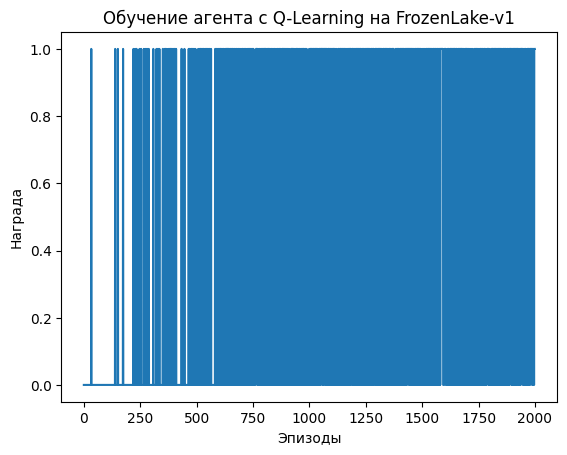

In [10]:
for episode in range(episodes):
    state = env.reset()[0]
    total_reward = 0
    for step in range(max_steps):
        # Выбор действия с учетом epsilon-жадной стратегии
        action = choose_action(Q_table, state, epsilon)

        # Выполняем действие
        next_state, reward, done, _, _ = env.step(action)

        # Обновляем Q-значение по уравнению Беллмана
        Q_table[state, action] = (1 - alpha) * Q_table[state, action] + \
            alpha * get_new_q_value(Q_table, state, action, reward, next_state, gamma)

        total_reward += reward
        state = next_state

        if done:
            break

    # Уменьшаем epsilon
    epsilon = get_new_epsilon(epsilon, min_epsilon, epsilon_decay)
    rewards.append(total_reward)

    if (episode + 1) % 200 == 0:
        print(f"Эпизод: {episode + 1}, средняя награда: {np.mean(rewards[-200:])}, epsilon: {epsilon:.3f}")

# График зависимости награды от эпизодов
plt.plot(range(episodes), rewards)
plt.xlabel("Эпизоды")
plt.ylabel("Награда")
plt.title("Обучение агента с Q-Learning на FrozenLake-v1")
plt.show()


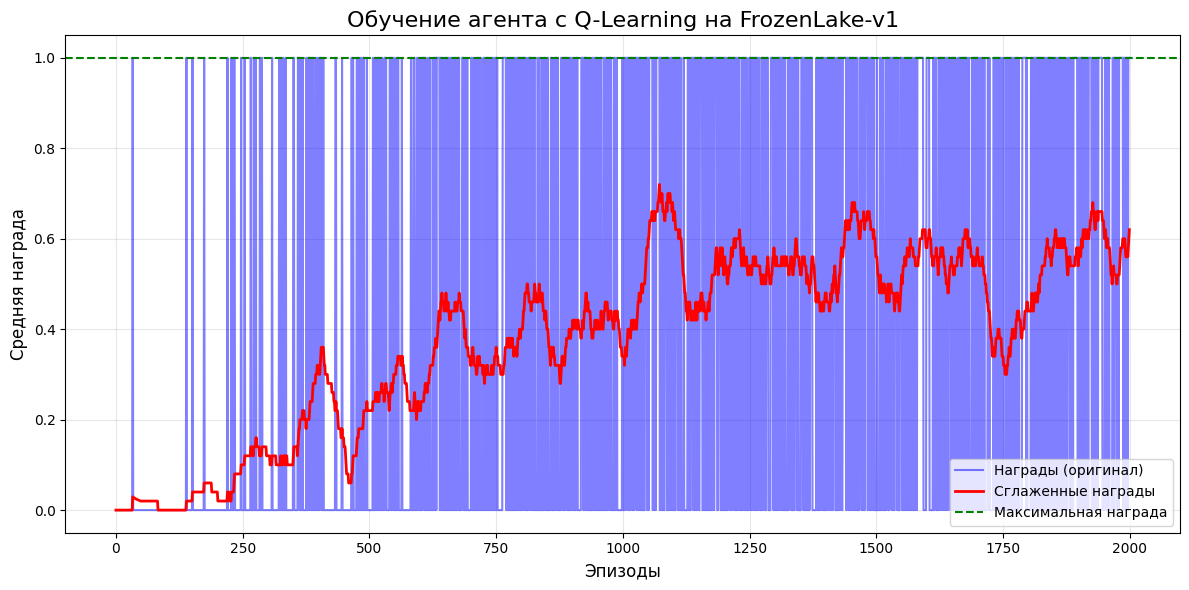

In [12]:
# Сглаживание наград
def smooth_rewards(rewards, window=50):
    smoothed = []
    for i in range(len(rewards)):
        start = max(0, i - window + 1)
        smoothed.append(np.mean(rewards[start:i+1]))
    return smoothed

smoothed_rewards = smooth_rewards(rewards)

# Построение графика
plt.figure(figsize=(12, 6))
plt.plot(rewards, label="Награды (оригинал)", alpha=0.5, color="blue")
plt.plot(smoothed_rewards, label="Сглаженные награды", color="red", linewidth=2)
plt.axhline(y=max(rewards), color='green', linestyle='--', label="Максимальная награда")

# Настройка визуального вида
plt.grid(alpha=0.3)
plt.xlabel("Эпизоды", fontsize=12)
plt.ylabel("Средняя награда", fontsize=12)
plt.title("Обучение агента с Q-Learning на FrozenLake-v1", fontsize=16)
plt.legend(loc="lower right", fontsize=10)
plt.tight_layout()

# Показ графика
plt.show()


Общая награда: 1.0


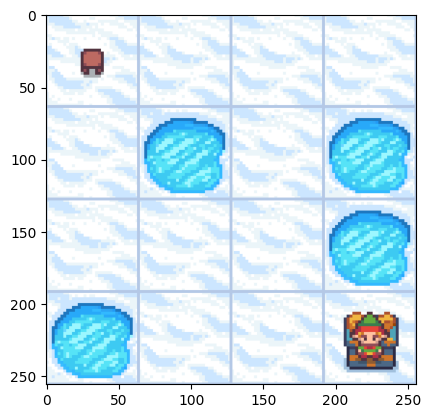

In [13]:
display.clear_output(wait=True)
state = env.reset()[0]
done = False
total_reward = 0
print(f"Эпизод {episode + 1}:")

while not done:
    # Выбор действия с использованием обученной Q-таблицы
    action = np.argmax(Q_table[state])

    # Выполняем действие
    state, reward, done, _, _ = env.step(action)
    total_reward += reward

    # Отображаем текущую визуализацию среды
    plt.imshow(env.render())
    display.display(plt.gcf())
    display.clear_output(wait=True)

print(f"Общая награда: {total_reward}")
